# Stock forecasting with Yahoo dataset from yfinance

This notebook performs time-series analysis on stock data from yfinance. First we import the data and define it as a dataframe with 6 features plus time.

## 1/. Package and data importing

In [43]:
from datetime import datetime
import yfinance as yf
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa import stattools
from arch.unitroot import KPSS, ADF
from statsmodels.tsa.seasonal import seasonal_decompose
import pandas as pd
from statsmodels.tsa.forecasting.stl import STLForecast
from statsmodels.tsa import arima

start_date = datetime(2005, 1, 1)
end_date = datetime(2021, 1, 1)
df = yf.download(
    'SPY',
    start=start_date,
    end = end_date
)

[*********************100%%**********************]  1 of 1 completed


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4028 entries, 2005-01-03 to 2020-12-31
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       4028 non-null   float64
 1   High       4028 non-null   float64
 2   Low        4028 non-null   float64
 3   Close      4028 non-null   float64
 4   Adj Close  4028 non-null   float64
 5   Volume     4028 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 220.3 KB


In [8]:
#Printing the dataframe head. Note that Volume consists of large order numbers compared to the other columns. May want to apply a transform on that if we use it.
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2005-01-03,121.559998,121.760002,119.900002,120.300003,83.623390,55748000
2005-01-04,120.459999,120.540001,118.440002,118.830002,82.601562,69167600
2005-01-05,118.739998,119.250000,118.000000,118.010002,82.031532,65667300
2005-01-06,118.440002,119.150002,118.260002,118.610001,82.448593,47814700
2005-01-07,118.970001,119.230003,118.129997,118.440002,82.330460,55847700


We look at "Open" prices for our study. Let us plot the data.

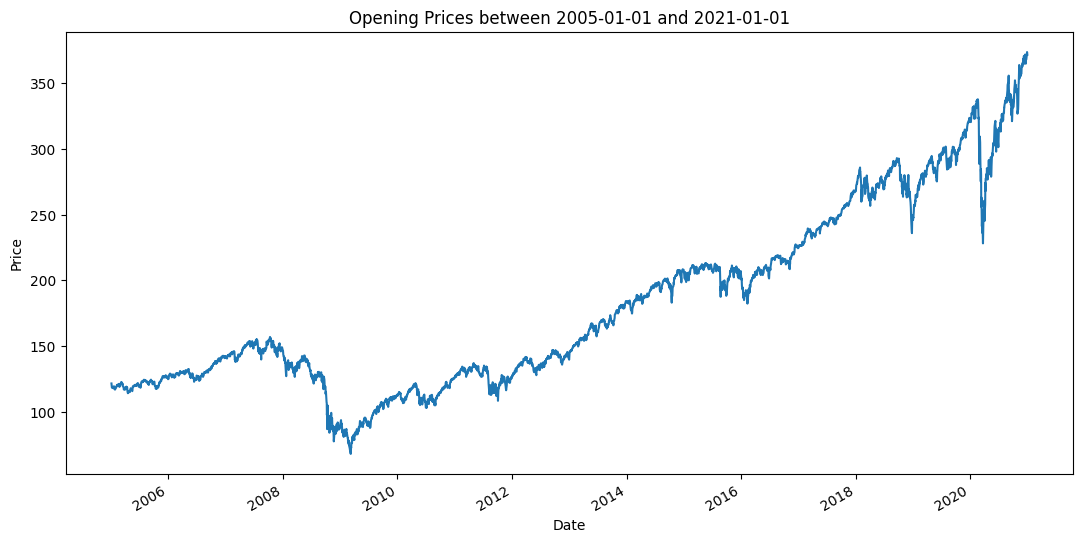

In [12]:
plt.figure(figsize=(13,6.5))
plt.title('Opening Prices between {} and {}'.format(
    start_date.date().isoformat(),
    end_date.date().isoformat()
))
df['Open'].plot()
plt.ylabel('Price')
plt.xlabel('Date');

Resampling for consistency

In [15]:
df1 = df.reset_index().resample('W', on="Date")['Open'].mean()
df1 = df1[df1.index.week < 53] # Dropping data that falls into 53rd week
df1 = df1.asfreq('W').fillna(method='ffill') # Setting the frequency to weeks and filling missing values with ffill: propagate last valid observation forward to next valid.

C:\Users\Lewis Sword\AppData\Local\Temp\ipykernel_18752\1332694234.py:2: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series. To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  df1 = df1[df1.index.week < 53]


In [16]:
df1.head()

Date
2005-01-09    119.634000
2005-01-16    118.398000
2005-01-23    118.290001
2005-01-30    117.200000
2005-02-06    118.663998
Freq: W-SUN, Name: Open, dtype: float64

## 2/. Autocorrelation and ADF, KPSS tests for stationarity

Next we move onto some autocorrelation checks, which again help determine the stationarity as much as trend and seasonality. Directly from the signal, this is clearly not the case anyway. 

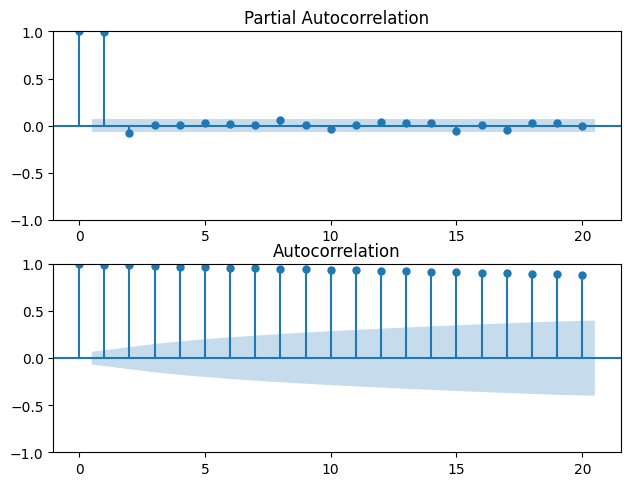

<Figure size 640x480 with 0 Axes>

In [39]:
fig, axs = plt.subplots(2)
fig.tight_layout()
plt.figure()
sm.graphics.tsa.plot_pacf(df1, lags=20, ax=axs[0])
sm.graphics.tsa.plot_acf(df1, lags=20, ax=axs[1])
plt.show()

These graphs show the correlation of the time-series with itself at lags of up to 20 time steps. It also demonstrates the confidence interval by the light blue region. Naturally the y-axis, known as $R$, shows correlation and at Lag =0, the feature "Open" is perfectly correlated with itself. This gradually drops on the autocorrelation plot, but almost instantaneously (Lag=2) for the partial autocorrelation.

The correlation is deemed significant if the data point extends beyond the confidence interval.

In [42]:
print(df1.mean())
print(df1.std())

181.1152219865343
68.79524334665406


Next let us look at an autoregression model, using statsmodels. 

- First and foremost, we see above that the time-series is not stationary: we need the mean and variance to be constant over time: no trend or seasonality.
- Augmented Dickey-Fuller (ADF) can give us a statistical measure of stationarity, let us implement one.

In [44]:
stattools.adfuller(df1)

(1.3246990005971804,
 0.9967437094273014,
 9,
 824,
 {'1%': -3.438310908190086,
  '5%': -2.8650539530590673,
  '10%': -2.5686411274036196},
 4325.685952218077)

- If the p-value from the ADF test is less than a chosen significance level (usually around 0.05), we reject the null hypothesis and conclude that the time series is weakly stationary.
- On the contrary, with our large 0.9967 p-value, we fail to reject the null hypothesis and understand that we simply cannot conclude the stationarity of the data from this test.

We can use other libraries to confirm these findings. For example, the arch library can compute the say ADF test and KPSS tests. 

- If the p-value from the KPSS test is less than a chosen significance level (usually 0.05), we reject the null hypothesis and conclude that the time series is not stationary around a deterministic trend. 

In [63]:
#!pip install arch

In [72]:
# ADF is arch's augmented Dickey-Fuller test
ADF(df1)

Test Statistic,1.325
P-value,0.997
Lags,9


In [73]:
KPSS(df1)

Test Statistic,3.872
P-value,0.000
Lags,18


With a KPSS p-value of 0, you have overwhelming evidence to reject the null hypothesis, indicating that the time series is not stationary around a deterministic trend.

So the time-series stationarity KPSS test reveals that the time-series is non-stationary, which means before we apply ARIMA or ARMA models, we must check the trend and seasonality. This is very conveniently accomplished using statsmodels.tsa.seasonal. The additive model they consider is very straightforward, our original signal is decomposed as 

$$Y_{t} = T_{t} + S_{t} + \epsilon_{t}$$

where $Y_{t}$ is our original signal, $T_{t}$ is the trend fit, $S_{t}$ is the seasonal fit and $\epsilon_{t}$ is the residual remainder.

- First it prints our original time-series.
- Second it models a trend on some fit.
- Third it gets the seasonal information.
- Fourth it provides the residual which is the part of the decomposition which cannot be explained by either trend or seasonal. 

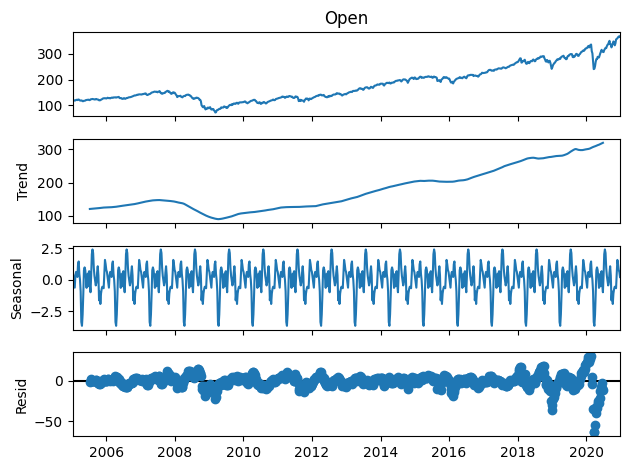

In [74]:
result = seasonal_decompose(df1, model='additive', period=52)
result.plot()
plt.show()

In [75]:
# We can also study the seasonal and trend data using the associated attributes
trend_comp = result.trend
seas_comp = result.seasonal
seas_comp

Date
2005-01-09    0.625814
2005-01-16    0.216625
2005-01-23   -0.221862
2005-01-30   -0.626819
2005-02-06    0.359397
                ...   
2020-11-29    1.586234
2020-12-06    1.249359
2020-12-13    0.792902
2020-12-20    0.625814
2020-12-27    0.216625
Freq: W-SUN, Name: seasonal, Length: 834, dtype: float64

Next we move onto the autoregression baring in mind our currently non-stationary data. Here we will check the parameters available that make the model stationary.

## 3/. ARIMA

So to employ ARIMA, we usually want a good idea of the parameters to base the model on. ARMA is:

$$ARMA(p,q): x_{t} = c + \epsilon_{t} + \sum_{i=1}^{p} \phi_{i} x_{t-i} + \sum_{j=0}^{q} \psi_{j} \epsilon_{t-j}$$

ARIMA develops on this with an integration filter, which establishes a new parameter $d$. $d$, is the number of times differences have been taken between current and previous values. Given our above discussion, the relevance of $d$ is by selecting an appropriate value for , you effectively remove any trend or seasonal components that might be present in the data, making it stationary. 

As a futher breakdown:

- $p$ is for the autoregressive model: $AR(p)$
- $d$ is for the integration
- $q$ is for the moving average: $MA(q)$

So how do we find good values for the differencing parameter $d$? We can use the pmdarima package to do so.

In [77]:
#!pip install pmdarima

In [92]:
from pmdarima.arima.utils import ndiffs
# ADF Test:
diff_test_adf=ndiffs(df1, test='adf')
diff_test_kpss=ndiffs(df1, test='kpss')
print("d for adf: ", diff_test_adf,"\nd for kpss:", diff_test_kpss)

d for adf:  1 
d for kpss: 1


Having acquired the differencing parameter we move on to the ARIMA implementation.

- Using the `.ARIMA` method, we supply the order a tuple corresponding to `(p,d,q)`.
- Note, we can try using a difference of 0 i.e. $d=0$, and we will get a warning that the time-series is not stationary "'Non-stationary starting autoregressive parameters'". This makes sense given above we found that we need a difference of 1.

In [111]:
mod = sm.tsa.arima.ARIMA(endog=df1, order=(1, 1, 0)) 
res = mod.fit()
print(res.summary())

                               SARIMAX Results                                
Dep. Variable:                   Open   No. Observations:                  834
Model:                 ARIMA(1, 1, 0)   Log Likelihood               -2211.813
Date:                Sun, 10 Mar 2024   AIC                           4427.626
Time:                        16:54:14   BIC                           4437.076
Sample:                    01-09-2005   HQIC                          4431.249
                         - 12-27-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3018      0.014     21.473      0.000       0.274       0.329
sigma2        11.8518      0.229     51.809      0.000      11.403      12.300
Ljung-Box (L1) (Q):                   0.20   Jarque-

Since ARIMA can't handle seasonality, out of the box, we implement an STLForecast wrapper that removes it then adds it back in.

In [165]:
mod = STLForecast(
  df1, sm.tsa.arima.ARIMA,
  model_kwargs=dict(order=(1, 1,0), trend="t")
)
res = mod.fit().model_result
print(res.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  834
Model:                 ARIMA(1, 1, 0)   Log Likelihood               -1965.555
Date:                Sun, 10 Mar 2024   AIC                           3937.110
Time:                        17:10:44   BIC                           3951.285
Sample:                    01-09-2005   HQIC                          3942.545
                         - 12-27-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.2771      0.119      2.327      0.020       0.044       0.511
ar.L1          0.2502      0.022     11.402      0.000       0.207       0.293
sigma2         6.5618      0.184     35.641      0.0

Note that we need to set trend="t" here so that the model includes a constant. If not, we would get a spurious regression.

## 4/. Forecasting 

Having made a fit to the model, we can start forecasting.

In [166]:
STEPS = 20
forecasts_df = res.get_forecast(steps=STEPS).summary_frame() 

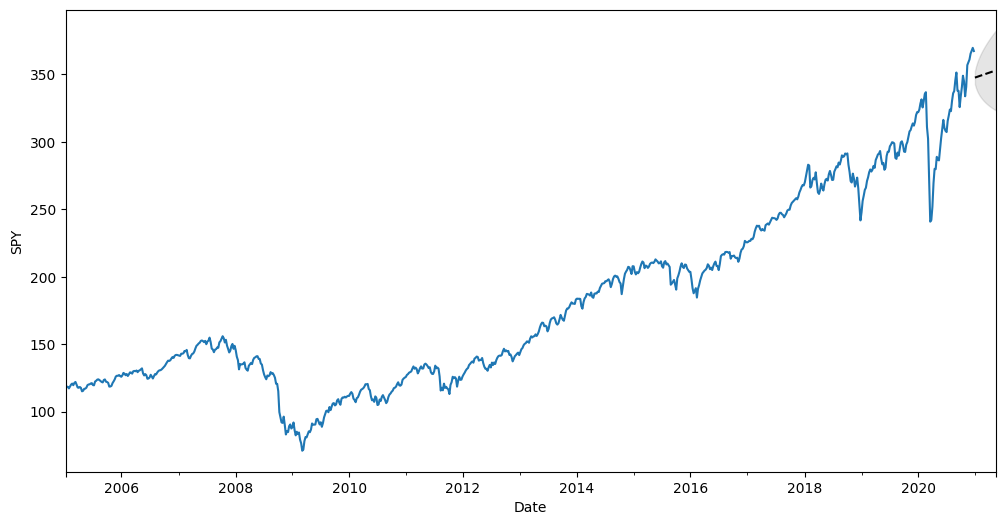

In [167]:
ax = df1.plot(figsize=(12, 6))
plt.ylabel('SPY')
forecasts_df['mean'].plot(style='k--')
ax.fill_between(
    forecasts_df.index,
    forecasts_df['mean_ci_lower'],
    forecasts_df['mean_ci_upper'],
    color='k',
    alpha=0.1
)

Note we have also introduced some confidence intervals around the main prediction line. This is a 95% confidence interval. Naturally as expected, this will get far wider as we look to infer a larger number of time steps in the series.

We have a choice over the $q$ parameter, and as such we can test it on a variety of values.

In [170]:
forecasts = []
qs = []
for q in range(0, 30, 10):
    mod = STLForecast(
            df1, sm.tsa.arima.ARIMA, 
            model_kwargs=dict(order=(0, 1, q), trend="t")
        )
    res = mod.fit().model_result
    print(f"aic ({q}): {res.aic}")
    forecasts.append(
            res.get_forecast(steps=STEPS).summary_frame()['mean']
        )
    qs.append(q)
forecasts_df = pd.concat(forecasts, axis=1)
forecasts_df.columns = qs

aic (0): 3989.010418491891
aic (10): 3934.3759092632354
aic (20): 3935.335534084144


The aic is a log-likelihood value, and the lower the better.

In [183]:
df1.last

<bound method NDFrame.last of Date
2005-01-09    119.634000
2005-01-16    118.398000
2005-01-23    118.290001
2005-01-30    117.200000
2005-02-06    118.663998
                 ...    
2020-11-29    361.114998
2020-12-06    365.444000
2020-12-13    367.577997
2020-12-20    369.754004
2020-12-27    367.384995
Freq: W-SUN, Name: Open, Length: 834, dtype: float64>

<Axes: xlabel='Date', ylabel='SPY'>

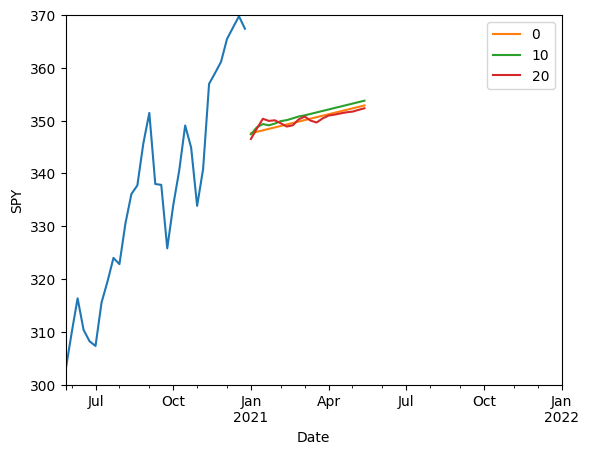

In [192]:
ax = df1.plot()
plt.ylabel('SPY')
#ax.set_xlim(pd.Timestamp('2020-11-29'), pd.Timestamp('2020-12-27'))
forecasts_df.plot(ax=ax,xlim=(pd.Timestamp('2020-05-29'), pd.Timestamp('2021-12-27')),ylim=(300,370))

The choice of $q=20$ appears to give more freedom in curve output. However, based on the aic return, the $q=10$ would win.

We could scan over all integer values to fine tune the output. Note that the pmdarima library has functionality for finding the optimal parameter values, and the SkTime library provides an implementation for automatic discovery of the optimal order of an ARIMA model: AutoARIMA.